In [1]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from matplotlib import cm
from mpl_toolkits import mplot3d

In [2]:
A_w = 2
B_w = 2
K = 100
N = 12 # Number of coin flips
Z = 9  # Number of heads
GRANULARITY = 100

$p(\theta, \omega) = p(\theta|\omega)p(\omega)$

In [3]:
theta = np.linspace(0, 1, GRANULARITY)
omega = np.linspace(0, 1, GRANULARITY)
THETA, OMEGA = np.meshgrid(theta, omega)
prior = np.multiply(beta.pdf(THETA, OMEGA * (K - 2) + 1, (1 - OMEGA) * (K - 2) + 1), beta.pdf(OMEGA, A_w, B_w))
prior = prior / np.sum(np.sum(prior))
# Transform probability mass into probability density
prior = prior / (theta[1] * omega[1])
marginal_theta = np.sum(prior, axis = 1) / prior.shape[0]
marginal_omega = np.sum(prior, axis = 0) / prior.shape[1]
marginal_theta_w_075 = prior[:, 75] / (np.sum(prior[:, 75]) * theta[1])
marginal_theta_w_025 = prior[:, 25] / (np.sum(prior[:, 75]) * theta[1])

In [4]:
def plot_prior():
    fig = plt.figure(constrained_layout = False)
    gs = fig.add_gridspec(4, 3)
    ax1 = fig.add_subplot(gs[0:2, 0], projection='3d')
    ax1.plot_surface(THETA, OMEGA, prior, cmap = cm.coolwarm, edgecolor = 'none')
    ax1.view_init(30, 250)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_zticks([])
    ax1.xaxis.labelpad = -15
    ax1.yaxis.labelpad = -15
    ax1.zaxis.labelpad = -15
    ax1.set_xlabel('theta')
    ax1.set_ylabel('omega')
    ax1.set_zlabel('prior')

    ax2 = fig.add_subplot(gs[0:2, 1])
    ax2.contourf(THETA, OMEGA, prior, cmap = cm.coolwarm)
    ax2.set_xlabel(r'$\theta$')
    ax2.set_ylabel(r'$\omega$')

    ax3 = fig.add_subplot(gs[0:2, 2])
    ax3.plot(marginal_omega, omega)
    ax3.set_xlabel(r'Marginal $p(\omega)$')
    ax3.set_ylabel(r'$\omega$')

    ax4 = fig.add_subplot(gs[2:4, 0])
    ax4.axis('off')
    parameters_str = '$A_{\omega}$ = ' + str(A_w) + ', $B_{\omega}$ = ' + str(B_w) + '\nK = ' + str(K)
    ax4.text(1.1, 0.65, 'Prior', transform = ax4.transAxes, fontsize = 18, horizontalalignment = 'right')
    ax4.text(1.1, 0.4, parameters_str, transform = ax4.transAxes, fontsize = 12, horizontalalignment = 'right')

    ax5 = fig.add_subplot(gs[2:4, 1])
    ax5.plot(theta, marginal_theta)
    ax5.set_xlabel(r'$\theta$')
    ax5.set_ylabel(r'Marginal $p(\theta)$')

    ax6 = fig.add_subplot(gs[2, 2])
    ax6.plot(theta, marginal_theta_w_075)
    ax6.set_xlabel(r'$\theta$')
    ax6.set_ylabel(r'$p(\theta|\omega=.75)$')

    ax7 = fig.add_subplot(gs[3, 2])
    ax7.plot(theta, marginal_theta_w_025)
    ax7.set_xlabel(r'$\theta$')
    ax7.set_ylabel(r'$p(\theta|\omega=.25)$')

    fig.set_figwidth(8)
    fig.set_figheight(5)
    plt.tight_layout()
    
    return [ax1, ax2, ax3, ax4, ax5, ax6, ax7]

$p(D|\theta, \omega) = \theta^{z}(1 - \theta)^{n-z}$

In [5]:
likelihood = np.multiply(np.power(THETA, Z), np.power(1 - THETA, N - Z))

In [6]:
def plot_likelihood():
    fig = plt.figure(constrained_layout = False)
    gs = fig.add_gridspec(2, 3)
    ax1 = fig.add_subplot(gs[:, 0], projection='3d')
    ax1.plot_surface(THETA, OMEGA, likelihood, cmap = cm.coolwarm, edgecolor = 'none')
    ax1.view_init(30, 250)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_zticks([])
    ax1.xaxis.labelpad = -15
    ax1.yaxis.labelpad = -15
    ax1.zaxis.labelpad = -15
    ax1.set_xlabel('theta')
    ax1.set_ylabel('omega')
    ax1.set_zlabel('likelihood')

    ax2 = fig.add_subplot(gs[:, 1])
    ax2.contourf(THETA, OMEGA, likelihood, cmap = cm.coolwarm)
    ax2.set_xlabel(r'$\theta$')
    ax2.set_ylabel(r'$\omega$')

    ax3 = fig.add_subplot(gs[:, 2])
    ax3.axis('off')
    data_str = 'D = ' + str(Z) + ' heads, ' + str(N - Z) + ' tails'
    ax3.text(0, 0.55, 'Likelihood', transform = ax3.transAxes, fontsize = 18, horizontalalignment = 'left')
    ax3.text(0, 0.4, data_str, transform = ax3.transAxes, fontsize = 12, horizontalalignment = 'left')


    fig.set_figwidth(8)
    fig.set_figheight(2.5)
    plt.tight_layout()

$p(\theta, \omega | D))$ is obtaining by multiplying each cell of the prior times each the corresponding cell in the likelihood grid and then normalising

In [7]:
posterior = np.multiply(prior, likelihood)
posterior = posterior / np.sum(np.sum(posterior))
posterior = posterior / (theta[1] * omega[1])
marginal_theta_p = np.sum(posterior, axis = 1) / posterior.shape[0]
marginal_omega_p = np.sum(posterior, axis = 0) / posterior.shape[1]
marginal_theta_w_075 = posterior[:, 75] / (np.sum(posterior[:, 75]) * theta[1])
marginal_theta_w_025 = posterior[:, 25] / (np.sum(posterior[:, 25]) * theta[1])

In [8]:
def plot_posterior():
    fig = plt.figure(constrained_layout = False)
    gs = fig.add_gridspec(4, 3)
    ax1 = fig.add_subplot(gs[0:2, 0], projection='3d')
    ax1.plot_surface(THETA, OMEGA, posterior, cmap = cm.coolwarm, edgecolor = 'none')
    ax1.view_init(30, 250)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_zticks([])
    ax1.xaxis.labelpad = -15
    ax1.yaxis.labelpad = -15
    ax1.zaxis.labelpad = -15
    ax1.set_xlabel('theta')
    ax1.set_ylabel('omega')
    ax1.set_zlabel('prior')

    ax2 = fig.add_subplot(gs[0:2, 1])
    ax2.contourf(THETA, OMEGA, posterior, cmap = cm.coolwarm)
    ax2.set_xlabel(r'$\theta$')
    ax2.set_ylabel(r'$\omega$')

    ax3 = fig.add_subplot(gs[0:2, 2])
    ax3.plot(marginal_omega_p, omega)
    ax3.set_xlabel(r'Marginal $p(\omega|D)$')
    ax3.set_ylabel(r'$\omega$')

    ax4 = fig.add_subplot(gs[2:4, 0])
    ax4.axis('off')
    ax4.text(1.1, 0.65, 'Posterior', transform = ax4.transAxes, fontsize = 18, horizontalalignment = 'right')

    ax5 = fig.add_subplot(gs[2:4, 1])
    ax5.plot(theta, marginal_theta_p)
    ax5.set_xlabel(r'$\theta$')
    ax5.set_ylabel(r'Marginal $p(\theta|D)$')

    ax6 = fig.add_subplot(gs[2, 2])
    ax6.plot(theta, marginal_theta_w_075)
    ax6.set_xlabel(r'$\theta$')
    ax6.set_ylabel(r'$p(\theta|\omega=.75, D)$')

    ax7 = fig.add_subplot(gs[3, 2])
    ax7.plot(theta, marginal_theta_w_025)
    ax7.set_xlabel(r'$\theta$')
    ax7.set_ylabel(r'$p(\theta|\omega=.25, D)$')

    fig.set_figwidth(8)
    fig.set_figheight(5)
    plt.tight_layout()
    
    return [ax1, ax2, ax3, ax4, ax5, ax6, ax7]

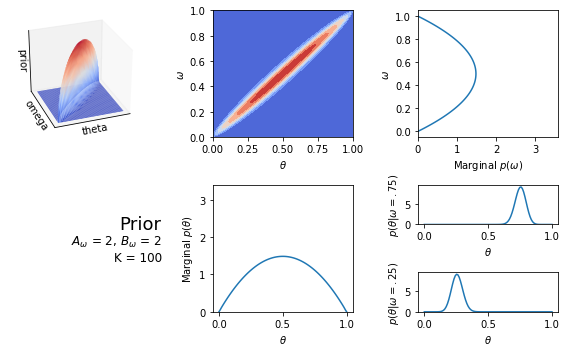

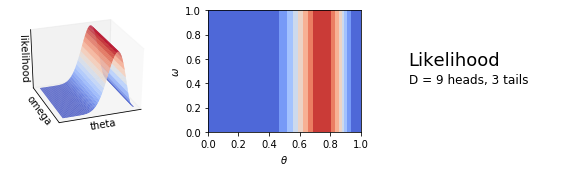

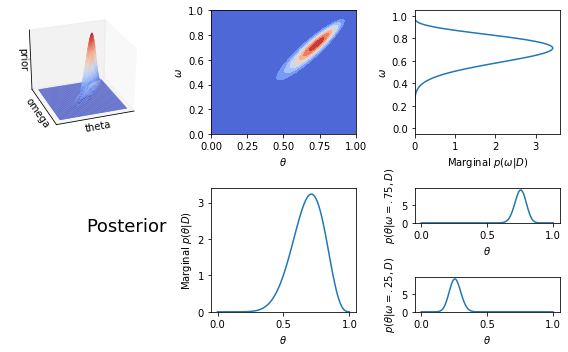

In [18]:
axes_prior = plot_prior()
plot_likelihood()
axes_posterior = plot_posterior()

max_marginal_w = max(axes_prior[2].get_xlim()[1], axes_posterior[2].get_xlim()[1])
max_marginal_theta = max(axes_prior[4].get_ylim()[1], axes_posterior[4].get_ylim()[1])
axes_prior[2].set_xlim([0, max_marginal_w])
axes_posterior[2].set_xlim([0, max_marginal_w])
axes_prior[4].set_ylim([0, max_marginal_theta])
axes_posterior[4].set_ylim([0, max_marginal_theta])

max_marginal_075 = max(axes_prior[5].get_ylim()[1], axes_posterior[5].get_ylim()[1])
max_marginal_025 = max(axes_prior[6].get_ylim()[1], axes_posterior[6].get_ylim()[1])
axes_prior[5].set_ylim([0, max_marginal_075])
axes_posterior[5].set_ylim([0, max_marginal_075])
axes_prior[6].set_ylim([0, max_marginal_025])
axes_posterior[6].set_ylim([0, max_marginal_025])

_ = _